In [1]:
import math
import random
import os
import time
import json
from functools import partial
from collections import defaultdict

import numpy as np
import pandas as pd

%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf

### Check Version

In [2]:
tf.__version__

'2.9.1'

### GPU Configuration

In [3]:
gpus = tf.config.list_physical_devices('GPU')

2022-11-03 00:23:35.740240: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-03 00:23:35.745441: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-03 00:23:35.745795: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [4]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
tf.config.experimental.set_memory_growth(gpus[0], True)

### Pandas Config

In [6]:
pd.set_option('display.max_column', None)

### Input Pipeline

In [7]:
IMG_WIDTH = 256
IMG_HEIGHT = 256

TRAIN_BATCH_SIZE = 4
VAL_BATCH_SIZE = 4

In [8]:
CROP_WIDTH = 227
CROP_HEIGHT = 227

In [9]:
foldFiles = ["adience/unprocessed/fold_0_data.txt",
             "adience/unprocessed/fold_1_data.txt",
             "adience/unprocessed/fold_2_data.txt",
             "adience/unprocessed/fold_3_data.txt",
             "adience/unprocessed/fold_4_data.txt"]

In [10]:
genderMap = defaultdict(lambda : np.NaN)
genderMap['m'] = 0
genderMap['f'] = 1

In [11]:
ages = ['(0, 2)', '(4, 6)', '(8, 13)', '(15, 20)', '(25, 32)', '(38, 43)', '(48, 53)', '(60, 100)']
ageMap = defaultdict(lambda : np.NaN)
for i,a in enumerate(ages):
    ageMap[a] = i

### Dataset Generation

Dataset generation pipeline:
Input: 
- foldFile - Path to fold file. Fold file Describes which images are in the fold and its corresponding labels
- imgBaseFolder - Base folder to search image from
- imgPrefix - Prefix of image file
- genderMap - Map from ['m', 'f', 'u', None], to one hot index
- ageMap - Map from age category to one hot index
- imgWidth - Resulting image width
- imgHeigh - Resulting image height
- batchSize - Int or None, batch size
- configureDs - Function accepting dataset for performance configurations
- preBatch - List of (name, functions) pair that will be mapped before batching. name is used as name parameters for tf graph 
- postBatch - List of (name, functions) that will be mapped after batching. name is used as name parameters for tf graph

The processing functions should have signature function(img, label) -> (img, label)

Pipeline

Read Fold File -> Preprocess filename and labels (dataframe) -> Convert filename and labels to numpy array -> Convert filename and labels to tf dataset -> Parse images and labels -> Configure Dataset for performance -> Pre-Batching preprocessing -> Batch -> Post-Batching preprocessing -> Output

Some preprocessing steps can only be done before and some can only be done after batching, thats why there are seperated pre and post batching list

In [12]:
def generateDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, batchSize, configureDs=None, preBatch=[], postBatch=[]):
    
    def parseImage(filename):
        img = tf.io.read_file(filename)
        img = tf.image.decode_jpeg(img)
        img = tf.image.resize(img, [imgHeight, imgWidth])
         
        return img
    
    # Read Fold File
    foldData = []
    for f in foldFiles:
        foldData.append(pd.read_csv(f, sep="\t"))
    foldData = pd.concat(foldData)
    
    # Form File Name
    foldData['filename'] = foldData.apply(lambda r: os.path.join(imgBaseFolder, r['user_id'], f"{imgPrefix}.{r['face_id']}.{r['original_image']}"), axis=1)
    
    # Generate Label One Hot Index
    foldData['gender_ind'] = foldData['gender'].map(genderMap)
    foldData['age_ind'] = foldData['age'].map(ageMap)
    
    # Remove dirty data
    foldData.dropna(subset=['gender_ind', 'age_ind'], inplace=True)
    
    # Dataframe to numpy
    filenames = foldData['filename'].to_numpy()
    
    genderIndex = foldData['gender_ind'].to_numpy().astype(int)
    ageIndex = foldData['age_ind'].to_numpy().astype(int)
    
    # Numpy to Dataset
    fnDs = tf.data.Dataset.from_tensor_slices(filenames)
    genderIndDs = tf.data.Dataset.from_tensor_slices(genderIndex)
    ageIndDs = tf.data.Dataset.from_tensor_slices(ageIndex)
    
    # Parse Images
    imageDs = fnDs.map(parseImage, num_parallel_calls=tf.data.AUTOTUNE, name="parse_image")
    
    # Parse Labels
    genderLabDs = genderIndDs.map(lambda x: tf.one_hot(x, genderDepth), num_parallel_calls=tf.data.AUTOTUNE, name="gender_one_hot")
    ageLabDs = ageIndDs.map(lambda x: tf.one_hot(x, ageDepth), num_parallel_calls=tf.data.AUTOTUNE, name="age_one_hot")
    
    # Combine Labels
    labelDs = tf.data.Dataset.zip((genderLabDs, ageLabDs), name="label_zip")
    labelDs = labelDs.map(lambda g,a: {"gender": g, "age": a}, num_parallel_calls=tf.data.AUTOTUNE, name='label_dict')
    
    # Combine Images and Labels into dataset
    ds = tf.data.Dataset.zip((imageDs, labelDs))
    
    # Configure Performance
    if(configureDs is not None):
        ds = configureDs(ds)
    
    # Pre Batch Preprocessing
    for n,f in preBatch:
        ds = ds.map(f, num_parallel_calls=tf.data.AUTOTUNE, name=n)
    
    # Batch
    if(batchSize is not None):
        ds = ds.batch(batchSize, name="ds_batch")
    
    # Post Batch Preprocessing
    for n,f in postBatch:
        ds = ds.map(f, num_parallel_calls=tf.data.AUTOTUNE, name=n)
    
    return ds

### Preprocessings

In [13]:
def trainConfigPerformance(ds):
    #ds = ds.cache()
    ds = ds.shuffle(buffer_size=100)
    ds = ds.repeat()
    return ds

In [14]:
def valConfigPerformance(ds):
    #ds = ds.cache()
    return ds

#### Preprocessing steps

In [15]:
def trainPreprocessA(img, lab):
        
        ud = tf.random.uniform([], dtype=tf.float32)
        udCond = tf.less(ud, 0.5)
        
        img = tf.cond(udCond, lambda: tf.image.flip_up_down(img), lambda: img)
        
        lr = tf.random.uniform([], dtype=tf.float32)
        lrCond = tf.less(lr, 0.5)
        
        img = tf.cond(lrCond, lambda: tf.image.flip_left_right(img), lambda: img)
        
        img = tf.image.random_brightness(img, 63/255)
        
        img = tf.image.random_contrast(img, 0.2, 1.8)
        
        return img, lab

In [16]:
def preprocessB(img, lab, rotL, rotH, shXL, shXH, shYL, shYH, zoomL, zoomH, hTransL, hTransH, vTransL, vTransH):
    shape = tf.shape(img)
    shapeF = tf.cast(shape, tf.float32)

    rRot = tf.random.uniform([shape[0]], minval=rotL, maxval=rotH, dtype=tf.float32)
    rShearX = tf.random.uniform([shape[0]], minval=shXL, maxval=shXH, dtype=tf.float32)
    rShearY = tf.random.uniform([shape[0]], minval=shYL, maxval=shYH, dtype=tf.float32)
    rZoom = tf.random.uniform([shape[0]], minval=zoomL, maxval=zoomH, dtype=tf.float32) #% Zoom
    rTx = tf.random.uniform([shape[0]], minval=hTransL, maxval=hTransH, dtype=tf.float32) #% Horiz Translation
    rTy = tf.random.uniform([shape[0]], minval=vTransL, maxval=vTransH, dtype=tf.float32) #% Vert Translation

    cT = tf.math.cos(rRot)
    sT = tf.math.sin(rRot)

    one = tf.ones([shape[0]], dtype=tf.float32)
    zero = tf.zeros([shape[0]], dtype=tf.float32)

    transC = tf.stack([[1, 0, -shapeF[2]/2], [0, 1, -shapeF[1]/2], [0, 0, 1]])
    transCI = tf.stack([[1, 0, shapeF[2]/2], [0, 1, shapeF[1]/2], [0, 0, 1]])

    trans = tf.transpose(tf.stack([[one, zero, rTx*shapeF[2]], [zero, one, rTy*shapeF[1]], [zero, zero, one]]), [2,0,1])
    rot = tf.transpose(tf.stack([[cT, -sT, zero], [sT, cT, zero], [zero, zero, one]]), [2,0,1])
    scale = tf.transpose(tf.stack([[rZoom, rShearX, zero], [rShearY, rZoom, zero], [zero, zero, one]]), [2,0,1])

    rotScale = rot@scale

    afTMat = transCI @ trans @ rotScale @ transC
    afT = tf.reshape(afTMat, [shape[0], -1])[:,:-1]

    img = tf.raw_ops.ImageProjectiveTransformV3(interpolation='NEAREST', images=img, transforms=afT, output_shape=shape[1:3], fill_value=0)

    return img, lab

In [17]:
def preprocessNoise(img, lab, gMean, gStd, spAmountP, spRatio, speckleVar):
        
    shape = tf.shape(img)
    shapeF = tf.cast(shape, tf.float32)

    # Gaussian Noise
    gNoise = tf.random.normal(shape, gMean, gStd)

    img += gNoise

    # Salt and pepper noise
    spMask = tf.cast(tf.math.less(tf.random.uniform(shape, dtype=tf.float32), spAmountP), tf.float32)
    spNoise = 255*tf.cast(tf.math.less(tf.random.uniform(shape, dtype=tf.float32), spRatio), tf.float32)

    img = tf.math.add(tf.math.multiply(img, 1.0 - spMask), tf.math.multiply(spNoise, spMask))

    # Speckles
    sNoise = speckleVar * tf.random.normal(shape)
    img = img + tf.math.multiply(img, sNoise)

    img = tf.clip_by_value(img, 0, 255)

    return img, lab

In [18]:
def clipValue(img, lab):
    img = tf.clip_by_value(img, 0.0, 255.0)
    return img, lab

In [19]:
def valPreprocessA(img, lab):
        
        img = tf.image.crop_to_bounding_box(img,
                                            (IMG_HEIGHT-CROP_HEIGHT) // 2,
                                            (IMG_WIDTH-CROP_WIDTH) // 2,
                                            CROP_HEIGHT,
                                            CROP_WIDTH)
        
        return img, lab

#### Label extractor 

In [20]:
def prepareLabel(img, lab):
    
    lab = lab['gender']
    
    return img, {"recon" : img, "gender" : lab }

### Generate Folds for K-Folds validation

In [21]:
def generateFoldDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, trainBatchSize, valBatchSize, trainConfigureDs=None, trainPreBatch=[], trainPostBatch=[], valConfigureDs=None, valPreBatch=[], valPostBatch=[]):
    '''
        Returns list of (train, validation) datasets
    '''
    
    N = len(foldFiles)
    
    folds = []
    
    for i in range(N):
        
        trainFiles = foldFiles[:i]
        if(i < N-1):
            trainFiles.extend(foldFiles[i+1:])
            
        valFiles = foldFiles[i]
        
        trainDs = generateDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, trainBatchSize, configureDs=trainConfigureDs, preBatch=trainPreBatch, postBatch=trainPostBatch)
        valDs = generateDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, valBatchSize, configureDs=valConfigureDs, preBatch=valPreBatch, postBatch=valPostBatch)
        
        folds.append((trainDs, valDs))
        
    return folds

In [22]:
genParams = {
            "rotation": [-math.pi, math.pi],
            "shearX": [-0.2, 0.2],
            "shearY": [-0.2, 0.2],
            
            "zoom": [0.8, 1.2], # +- 20%
            "hTranslation": [-0.2, 0.2], # +- 20%
            "vTranslation": [-0.2, 0.2], # +- 20%
            
            "gaussianMean": 0.0,
            "gaussianStd": 2.0,
            
            "spAmount": 0.0001,
            "spRatio": 0.5,
            
            "speckleVar": 0.01
        }

In [23]:
trainPreprocessB = partial(preprocessB,
                           rotL = genParams['rotation'][0],
                           rotH = genParams['rotation'][1],
                           shXL = genParams['shearX'][0],
                           shXH = genParams['shearX'][1], 
                           shYL = genParams['shearY'][0],
                           shYH = genParams['shearY'][1],
                           zoomL = genParams['zoom'][0],
                           zoomH = genParams['zoom'][1],
                           hTransL = genParams['hTranslation'][0],
                           hTransH = genParams['hTranslation'][1],
                           vTransL = genParams['vTranslation'][0],
                           vTransH = genParams['vTranslation'][1])

In [24]:
trainPreprocessC = partial(preprocessNoise,
                           gMean = genParams['gaussianMean'],
                           gStd = genParams['gaussianStd'],
                           spAmountP = genParams['spAmount'],
                           spRatio = genParams['spRatio'],
                           speckleVar = genParams['speckleVar'])

In [25]:
trainPreBatch = [("train_process_a", trainPreprocessA)]
trainPostBatch = [("train_process_b", trainPreprocessB),
                  ("train_process_c", trainPreprocessC),
                  ("train_clip", clipValue),
                  ("train_prepare_label", prepareLabel)]

valPreBatch = [("val_prepare_label", prepareLabel)]

In [26]:
folds = generateFoldDs(foldFiles, "adience/faces", "coarse_tilt_aligned_face", genderMap, ageMap, 2, 8, 
                       IMG_WIDTH, IMG_HEIGHT, TRAIN_BATCH_SIZE, VAL_BATCH_SIZE, 
                       trainConfigureDs=trainConfigPerformance, trainPreBatch=trainPreBatch, 
                       trainPostBatch=trainPostBatch,
                       valConfigureDs=valConfigPerformance, valPreBatch=valPreBatch)

2022-11-03 00:23:36.016097: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-03 00:23:36.016913: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-03 00:23:36.017239: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-03 00:23:36.017510: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [27]:
len(folds)

5

### Check data

In [28]:
for x,y in folds[0][0].take(1):
    pass

In [29]:
x

<tf.Tensor: shape=(4, 256, 256, 3), dtype=float32, numpy=
array([[[[2.5500000e+02, 2.5500000e+02, 2.5500000e+02],
         [2.5500000e+02, 2.5500000e+02, 2.5500000e+02],
         [2.5500000e+02, 2.5500000e+02, 2.5500000e+02],
         ...,
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 2.7836032e+00, 2.5959554e+00],
         [6.6752911e-02, 0.0000000e+00, 0.0000000e+00]],

        [[2.5500000e+02, 2.5500000e+02, 2.5500000e+02],
         [2.5500000e+02, 2.5500000e+02, 2.5500000e+02],
         [2.5500000e+02, 2.5500000e+02, 2.5500000e+02],
         ...,
         [0.0000000e+00, 1.7890173e+00, 0.0000000e+00],
         [0.0000000e+00, 1.5060087e-01, 2.5216260e+00],
         [0.0000000e+00, 1.3100664e-01, 0.0000000e+00]],

        [[2.5500000e+02, 2.5500000e+02, 2.5500000e+02],
         [2.5213969e+02, 2.5500000e+02, 2.5043179e+02],
         [2.5500000e+02, 2.5500000e+02, 2.5441646e+02],
         ...,
         [2.5450143e-01, 0.0000000e+00, 3.9345469e+00],


In [30]:
y

{'recon': <tf.Tensor: shape=(4, 256, 256, 3), dtype=float32, numpy=
 array([[[[2.5500000e+02, 2.5500000e+02, 2.5500000e+02],
          [2.5500000e+02, 2.5500000e+02, 2.5500000e+02],
          [2.5500000e+02, 2.5500000e+02, 2.5500000e+02],
          ...,
          [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
          [0.0000000e+00, 2.7836032e+00, 2.5959554e+00],
          [6.6752911e-02, 0.0000000e+00, 0.0000000e+00]],
 
         [[2.5500000e+02, 2.5500000e+02, 2.5500000e+02],
          [2.5500000e+02, 2.5500000e+02, 2.5500000e+02],
          [2.5500000e+02, 2.5500000e+02, 2.5500000e+02],
          ...,
          [0.0000000e+00, 1.7890173e+00, 0.0000000e+00],
          [0.0000000e+00, 1.5060087e-01, 2.5216260e+00],
          [0.0000000e+00, 1.3100664e-01, 0.0000000e+00]],
 
         [[2.5500000e+02, 2.5500000e+02, 2.5500000e+02],
          [2.5213969e+02, 2.5500000e+02, 2.5043179e+02],
          [2.5500000e+02, 2.5500000e+02, 2.5441646e+02],
          ...,
          [2.5450143e-01, 

<IPython.core.display.Javascript object>


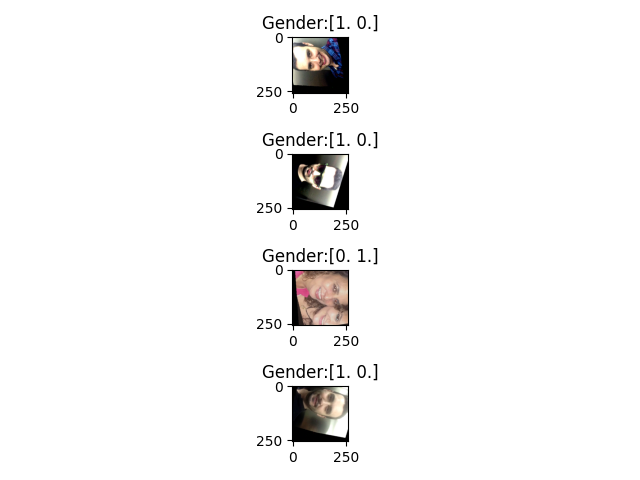

In [31]:
fig1, ax1 = plt.subplots(nrows=TRAIN_BATCH_SIZE, ncols=1)

if(TRAIN_BATCH_SIZE is None or TRAIN_BATCH_SIZE == 1):
    ax1.imshow(x/255)
    ax1.set_title(y)
else:
    for i in range(TRAIN_BATCH_SIZE):
        ax1[i].imshow(x[i]/255)
        ax1[i].set_title(f"Gender:{y['gender'][i]}")
        
plt.tight_layout()

### Model

In [32]:
def createModel(latentSize):
    inp = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

    encoder = tf.keras.Sequential([
        tf.keras.layers.Conv2D(64, 3, strides=(2,2), padding='same', activation='relu', name='enc_conv1'),
        tf.keras.layers.Conv2D(128, 3, strides=(2,2), padding='same', activation='relu', name='enc_conv2'),
        tf.keras.layers.Conv2D(256, 3, strides=(2,2), padding='same', activation='relu', name='enc_conv3'),
        tf.keras.layers.Conv2D(128, 3, strides=(2,2), padding='same', activation='relu', name='enc_conv4'),
        tf.keras.layers.Conv2D(64, 3, strides=(2,2), padding='same', activation='relu', name='enc_conv5'),
        tf.keras.layers.Flatten(name="enc_flat"),
        tf.keras.layers.Dense(latentSize, name="enc_out")
    ], name='enc')
    
    decoder = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(latentSize), name='dec_inp'),
        tf.keras.layers.Dense(8*8*64, activation='relu', name='dec_fc1'),
        tf.keras.layers.Reshape(target_shape=(8,8,64), name='dec_reshape'),
        tf.keras.layers.Conv2DTranspose(128, 3, strides=(2,2), padding='same', activation='relu', name='dec_deconv1'),
        tf.keras.layers.Conv2DTranspose(256, 3, strides=(2,2), padding='same', activation='relu', name='dec_deconv2'),
        tf.keras.layers.Conv2DTranspose(128, 3, strides=(2,2), padding='same', activation='relu', name='dec_deconv3'),
        tf.keras.layers.Conv2DTranspose(64, 3, strides=(2,2), padding='same', activation='relu', name='dec_deconv4'),
        tf.keras.layers.Conv2DTranspose(3, 3, strides=(2,2), padding='same', activation='tanh', name='dec_deconv5')
    ], name='dec')

    fc1 = tf.keras.layers.Dense(128, activation='relu', name='fc1')
    do1 = tf.keras.layers.Dropout(0.5, name='do1')

    fc2 = tf.keras.layers.Dense(2, activation='softmax', name='gender_out')
    
    # Preprocess Input
    preInp = inp / 127.5 - 1.0
    
    latent = encoder(preInp)
    recon = decoder(latent)
    recon = tf.math.multiply((recon + 1.0), 127.5, name='recon')
    
    o = fc1(latent)
    o = do1(o)
    
    outLab = fc2(o)
    
    model = tf.keras.models.Model(inputs=inp, outputs={"recon": recon, "gender": outLab}, name='AE_9')
    
    #encoder.summary()
    #decoder.summary()
    
    return model

In [33]:
LATENT_SIZE = 64

In [34]:
model = createModel(LATENT_SIZE)

In [35]:
model.summary()

Model: "AE_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 tf.math.subtract (TFOpLambda)  (None, 256, 256, 3)  0           ['tf.math.truediv[0][0]']        
                                                                                                  
 enc (Sequential)               (None, 64)           1001856     ['tf.math.subtract[0][0]']    

### Compile Model

In [36]:
STEPS_PER_EPOCH = 1000
EPOCH = 300

START_EPOCH = 0
END_EPOCH = START_EPOCH + EPOCH

#### Learning Rate Schedule

In [37]:
def schedule(epoch, lr):
    return lr

In [38]:
logBasePath = "log/AE_9"
logPrefix = "log"

In [39]:
for i, (train, val) in enumerate([folds[0]]):
    
    model = createModel(LATENT_SIZE)
    
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    loss = {"gender": tf.keras.losses.CategoricalCrossentropy(), "recon": tf.keras.losses.MeanSquaredError()}
    lossWeight = {"gender": 2500, "recon": 1}
    metrics = {"gender": 'accuracy'}
    
    model.compile(optimizer=opt, loss=loss, loss_weights=lossWeight, metrics=metrics)
    
    tboardCb = tf.keras.callbacks.TensorBoard(log_dir=f"{logBasePath}/{logPrefix}_{i}", histogram_freq=1, profile_batch=(2,10))
    lrSchedule = tf.keras.callbacks.LearningRateScheduler(schedule)
    
    cbs = [tboardCb]
    
    model.evaluate(val)
    model.fit(train, initial_epoch=START_EPOCH, epochs=END_EPOCH, steps_per_epoch=STEPS_PER_EPOCH, callbacks=cbs, validation_data=val)

2022-11-03 00:23:39.646244: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2022-11-03 00:23:39.646265: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.
2022-11-03 00:23:39.646285: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1665] Profiler found 1 GPUs
2022-11-03 00:23:39.727802: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.
2022-11-03 00:23:39.729076: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1799] CUPTI activity buffer flushed
2022-11-03 00:23:40.355345: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101


  13/3528 [..............................] - ETA: 14s - loss: 7146.7368 - gender_out_loss: 0.6926 - tf.math.multiply_1_loss: 5415.3340 - gender_out_accuracy: 0.5192    

2022-11-03 00:23:41.079505: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


3528/3528 [==============================] - 15s 4ms/step - loss: 7724.0322 - gender_out_loss: 0.6933 - tf.math.multiply_1_loss: 5990.7168 - gender_out_accuracy: 0.4872
Epoch 1/300
   1/1000 [..............................] - ETA: 13:55 - loss: 8348.5205 - gender_out_loss: 0.7049 - tf.math.multiply_1_loss: 6586.3223 - gender_out_accuracy: 0.0000e+00

2022-11-03 00:23:55.431569: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2022-11-03 00:23:55.431666: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.


   8/1000 [..............................] - ETA: 1:11 - loss: 10851.5205 - gender_out_loss: 1.4753 - tf.math.multiply_1_loss: 7163.3740 - gender_out_accuracy: 0.5625   

2022-11-03 00:23:55.950979: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-11-03 00:23:55.952022: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1799] CUPTI activity buffer flushed
2022-11-03 00:23:55.986329: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:521]  GpuTracer has collected 3188 callback api events and 3147 activity events. 
2022-11-03 00:23:56.015741: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.
2022-11-03 00:23:56.055240: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: log/AE_9/log_0/plugins/profile/2022_11_03_00_23_56

2022-11-03 00:23:56.109899: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to log/AE_9/log_0/plugins/profile/2022_11_03_00_23_56/rachanon-pc1.trace.json.gz
2022-11-03 00:23:56.151442: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: log/A

  30/1000 [..............................] - ETA: 30s - loss: 8123.6411 - gender_out_loss: 0.8750 - tf.math.multiply_1_loss: 5936.0278 - gender_out_accuracy: 0.5583

2022-11-03 00:23:56.156927: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to log/AE_9/log_0/plugins/profile/2022_11_03_00_23_56/rachanon-pc1.memory_profile.json.gz
2022-11-03 00:23:56.157779: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: log/AE_9/log_0/plugins/profile/2022_11_03_00_23_56
Dumped tool data for xplane.pb to log/AE_9/log_0/plugins/profile/2022_11_03_00_23_56/rachanon-pc1.xplane.pb
Dumped tool data for overview_page.pb to log/AE_9/log_0/plugins/profile/2022_11_03_00_23_56/rachanon-pc1.overview_page.pb
Dumped tool data for input_pipeline.pb to log/AE_9/log_0/plugins/profile/2022_11_03_00_23_56/rachanon-pc1.input_pipeline.pb
Dumped tool data for tensorflow_stats.pb to log/AE_9/log_0/plugins/profile/2022_11_03_00_23_56/rachanon-pc1.tensorflow_stats.pb
Dumped tool data for kernel_stats.pb to log/AE_9/log_0/plugins/profile/2022_11_03_00_23_56/rachanon-pc1.kernel_stats.pb



1000/1000 [==============================] - 23s 22ms/step - loss: 3990.9290 - gender_out_loss: 0.6814 - tf.math.multiply_1_loss: 2287.5378 - gender_out_accuracy: 0.5938 - val_loss: 3592.4792 - val_gender_out_loss: 0.6914 - val_tf.math.multiply_1_loss: 1864.1000 - val_gender_out_accuracy: 0.5416
Epoch 2/300
1000/1000 [==============================] - 21s 21ms/step - loss: 3113.1838 - gender_out_loss: 0.6461 - tf.math.multiply_1_loss: 1497.8518 - gender_out_accuracy: 0.6317 - val_loss: 3243.6179 - val_gender_out_loss: 0.6824 - val_tf.math.multiply_1_loss: 1537.6746 - val_gender_out_accuracy: 0.5667
Epoch 3/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2887.0774 - gender_out_loss: 0.6468 - tf.math.multiply_1_loss: 1270.0343 - gender_out_accuracy: 0.6097 - val_loss: 3172.7976 - val_gender_out_loss: 0.6904 - val_tf.math.multiply_1_loss: 1446.7112 - val_gender_out_accuracy: 0.5304
Epoch 4/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2882.8

1000/1000 [==============================] - 21s 21ms/step - loss: 2464.1184 - gender_out_loss: 0.6274 - tf.math.multiply_1_loss: 895.7128 - gender_out_accuracy: 0.6373 - val_loss: 3204.3228 - val_gender_out_loss: 0.8280 - val_tf.math.multiply_1_loss: 1134.2013 - val_gender_out_accuracy: 0.5443
Epoch 28/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2596.6582 - gender_out_loss: 0.6652 - tf.math.multiply_1_loss: 933.7128 - gender_out_accuracy: 0.6010 - val_loss: 2858.9377 - val_gender_out_loss: 0.6853 - val_tf.math.multiply_1_loss: 1145.6429 - val_gender_out_accuracy: 0.5680
Epoch 29/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2581.8835 - gender_out_loss: 0.6606 - tf.math.multiply_1_loss: 930.4123 - gender_out_accuracy: 0.6087 - val_loss: 2787.5186 - val_gender_out_loss: 0.6678 - val_tf.math.multiply_1_loss: 1118.0293 - val_gender_out_accuracy: 0.5774
Epoch 30/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2541.2

1000/1000 [==============================] - 21s 21ms/step - loss: 2563.0542 - gender_out_loss: 0.6717 - tf.math.multiply_1_loss: 883.8987 - gender_out_accuracy: 0.5825 - val_loss: 2794.9407 - val_gender_out_loss: 0.6890 - val_tf.math.multiply_1_loss: 1072.5430 - val_gender_out_accuracy: 0.5617
Epoch 54/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2538.4622 - gender_out_loss: 0.6617 - tf.math.multiply_1_loss: 884.3103 - gender_out_accuracy: 0.6112 - val_loss: 2893.1274 - val_gender_out_loss: 0.6821 - val_tf.math.multiply_1_loss: 1187.9244 - val_gender_out_accuracy: 0.5637
Epoch 55/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2525.9102 - gender_out_loss: 0.6514 - tf.math.multiply_1_loss: 897.3566 - gender_out_accuracy: 0.6263 - val_loss: 2734.7666 - val_gender_out_loss: 0.6680 - val_tf.math.multiply_1_loss: 1064.7485 - val_gender_out_accuracy: 0.5807
Epoch 56/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2511.4

1000/1000 [==============================] - 21s 21ms/step - loss: 2499.1184 - gender_out_loss: 0.6634 - tf.math.multiply_1_loss: 840.5148 - gender_out_accuracy: 0.5950 - val_loss: 2759.8079 - val_gender_out_loss: 0.6791 - val_tf.math.multiply_1_loss: 1062.0007 - val_gender_out_accuracy: 0.5545
Epoch 80/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2421.2668 - gender_out_loss: 0.6219 - tf.math.multiply_1_loss: 866.6002 - gender_out_accuracy: 0.6568 - val_loss: 2803.4434 - val_gender_out_loss: 0.6764 - val_tf.math.multiply_1_loss: 1112.4380 - val_gender_out_accuracy: 0.5906
Epoch 81/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2556.2083 - gender_out_loss: 0.6654 - tf.math.multiply_1_loss: 892.8060 - gender_out_accuracy: 0.5947 - val_loss: 2758.0994 - val_gender_out_loss: 0.6797 - val_tf.math.multiply_1_loss: 1058.7498 - val_gender_out_accuracy: 0.5504
Epoch 82/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2545.3

1000/1000 [==============================] - 21s 21ms/step - loss: 2485.4771 - gender_out_loss: 0.6416 - tf.math.multiply_1_loss: 881.5916 - gender_out_accuracy: 0.6323 - val_loss: 2735.0198 - val_gender_out_loss: 0.6743 - val_tf.math.multiply_1_loss: 1049.2994 - val_gender_out_accuracy: 0.5676
Epoch 106/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2526.7568 - gender_out_loss: 0.6675 - tf.math.multiply_1_loss: 858.0379 - gender_out_accuracy: 0.5925 - val_loss: 2844.2219 - val_gender_out_loss: 0.7094 - val_tf.math.multiply_1_loss: 1070.7513 - val_gender_out_accuracy: 0.5370
Epoch 107/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2523.4614 - gender_out_loss: 0.6639 - tf.math.multiply_1_loss: 863.6465 - gender_out_accuracy: 0.6015 - val_loss: 2788.2766 - val_gender_out_loss: 0.6771 - val_tf.math.multiply_1_loss: 1095.4521 - val_gender_out_accuracy: 0.5646
Epoch 108/300
1000/1000 [==============================] - 21s 21ms/step - loss: 249

1000/1000 [==============================] - 21s 21ms/step - loss: 2523.2822 - gender_out_loss: 0.6580 - tf.math.multiply_1_loss: 878.4000 - gender_out_accuracy: 0.6105 - val_loss: 2854.1042 - val_gender_out_loss: 0.6941 - val_tf.math.multiply_1_loss: 1118.7863 - val_gender_out_accuracy: 0.5374
Epoch 132/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2513.1270 - gender_out_loss: 0.6635 - tf.math.multiply_1_loss: 854.2529 - gender_out_accuracy: 0.6025 - val_loss: 2717.6238 - val_gender_out_loss: 0.6639 - val_tf.math.multiply_1_loss: 1057.7878 - val_gender_out_accuracy: 0.5964
Epoch 133/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2396.5928 - gender_out_loss: 0.6215 - tf.math.multiply_1_loss: 842.9535 - gender_out_accuracy: 0.6610 - val_loss: 3056.7866 - val_gender_out_loss: 0.7638 - val_tf.math.multiply_1_loss: 1147.1964 - val_gender_out_accuracy: 0.5472
Epoch 134/300
1000/1000 [==============================] - 21s 21ms/step - loss: 255

1000/1000 [==============================] - 21s 21ms/step - loss: 2474.5059 - gender_out_loss: 0.6314 - tf.math.multiply_1_loss: 895.9082 - gender_out_accuracy: 0.6453 - val_loss: 2839.2341 - val_gender_out_loss: 0.7111 - val_tf.math.multiply_1_loss: 1061.6014 - val_gender_out_accuracy: 0.5550
Epoch 158/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2458.9626 - gender_out_loss: 0.6434 - tf.math.multiply_1_loss: 850.4719 - gender_out_accuracy: 0.6230 - val_loss: 2730.5127 - val_gender_out_loss: 0.6627 - val_tf.math.multiply_1_loss: 1073.8387 - val_gender_out_accuracy: 0.5864
Epoch 159/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2529.7163 - gender_out_loss: 0.6625 - tf.math.multiply_1_loss: 873.4007 - gender_out_accuracy: 0.6080 - val_loss: 2758.2349 - val_gender_out_loss: 0.6747 - val_tf.math.multiply_1_loss: 1071.4208 - val_gender_out_accuracy: 0.5739
Epoch 160/300
1000/1000 [==============================] - 21s 21ms/step - loss: 248

1000/1000 [==============================] - 21s 21ms/step - loss: 2492.5146 - gender_out_loss: 0.6546 - tf.math.multiply_1_loss: 856.1172 - gender_out_accuracy: 0.5915 - val_loss: 2773.3953 - val_gender_out_loss: 0.6676 - val_tf.math.multiply_1_loss: 1104.4763 - val_gender_out_accuracy: 0.5794
Epoch 184/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2526.7034 - gender_out_loss: 0.6592 - tf.math.multiply_1_loss: 878.7111 - gender_out_accuracy: 0.6072 - val_loss: 2731.6191 - val_gender_out_loss: 0.6759 - val_tf.math.multiply_1_loss: 1041.9614 - val_gender_out_accuracy: 0.5812
Epoch 185/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2504.4832 - gender_out_loss: 0.6606 - tf.math.multiply_1_loss: 852.8892 - gender_out_accuracy: 0.6003 - val_loss: 2775.0796 - val_gender_out_loss: 0.6815 - val_tf.math.multiply_1_loss: 1071.3254 - val_gender_out_accuracy: 0.5739
Epoch 186/300
1000/1000 [==============================] - 21s 21ms/step - loss: 242

1000/1000 [==============================] - 21s 21ms/step - loss: 2537.2861 - gender_out_loss: 0.6711 - tf.math.multiply_1_loss: 859.5764 - gender_out_accuracy: 0.5950 - val_loss: 2715.1567 - val_gender_out_loss: 0.6679 - val_tf.math.multiply_1_loss: 1045.5304 - val_gender_out_accuracy: 0.5825
Epoch 210/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2482.8206 - gender_out_loss: 0.6450 - tf.math.multiply_1_loss: 870.2811 - gender_out_accuracy: 0.6352 - val_loss: 2827.7961 - val_gender_out_loss: 0.7030 - val_tf.math.multiply_1_loss: 1070.2694 - val_gender_out_accuracy: 0.5466
Epoch 211/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2458.1438 - gender_out_loss: 0.6414 - tf.math.multiply_1_loss: 854.5833 - gender_out_accuracy: 0.6248 - val_loss: 2889.2148 - val_gender_out_loss: 0.7101 - val_tf.math.multiply_1_loss: 1114.0776 - val_gender_out_accuracy: 0.5159
Epoch 212/300
1000/1000 [==============================] - 21s 21ms/step - loss: 253

1000/1000 [==============================] - 21s 21ms/step - loss: 2502.5552 - gender_out_loss: 0.6593 - tf.math.multiply_1_loss: 854.4208 - gender_out_accuracy: 0.6148 - val_loss: 2736.7534 - val_gender_out_loss: 0.6733 - val_tf.math.multiply_1_loss: 1053.5043 - val_gender_out_accuracy: 0.5786
Epoch 236/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2483.7000 - gender_out_loss: 0.6418 - tf.math.multiply_1_loss: 879.2847 - gender_out_accuracy: 0.6122 - val_loss: 2738.5435 - val_gender_out_loss: 0.6743 - val_tf.math.multiply_1_loss: 1052.8225 - val_gender_out_accuracy: 0.5770
Epoch 237/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2516.7646 - gender_out_loss: 0.6665 - tf.math.multiply_1_loss: 850.4244 - gender_out_accuracy: 0.6108 - val_loss: 2728.5786 - val_gender_out_loss: 0.6771 - val_tf.math.multiply_1_loss: 1035.7654 - val_gender_out_accuracy: 0.5613
Epoch 238/300
1000/1000 [==============================] - 21s 21ms/step - loss: 249

1000/1000 [==============================] - 21s 21ms/step - loss: 2551.8782 - gender_out_loss: 0.6699 - tf.math.multiply_1_loss: 877.1730 - gender_out_accuracy: 0.5928 - val_loss: 2712.0034 - val_gender_out_loss: 0.6652 - val_tf.math.multiply_1_loss: 1048.9448 - val_gender_out_accuracy: 0.5778
Epoch 262/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2539.0344 - gender_out_loss: 0.6695 - tf.math.multiply_1_loss: 865.3541 - gender_out_accuracy: 0.5853 - val_loss: 2715.6992 - val_gender_out_loss: 0.6685 - val_tf.math.multiply_1_loss: 1044.5175 - val_gender_out_accuracy: 0.5791
Epoch 263/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2497.6658 - gender_out_loss: 0.6484 - tf.math.multiply_1_loss: 876.6815 - gender_out_accuracy: 0.6438 - val_loss: 2720.4187 - val_gender_out_loss: 0.6694 - val_tf.math.multiply_1_loss: 1047.0024 - val_gender_out_accuracy: 0.5640
Epoch 264/300
1000/1000 [==============================] - 21s 21ms/step - loss: 247

1000/1000 [==============================] - 21s 21ms/step - loss: 2503.5833 - gender_out_loss: 0.6608 - tf.math.multiply_1_loss: 851.5253 - gender_out_accuracy: 0.6053 - val_loss: 3033.3438 - val_gender_out_loss: 0.7850 - val_tf.math.multiply_1_loss: 1070.8147 - val_gender_out_accuracy: 0.5011
Epoch 288/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2436.9326 - gender_out_loss: 0.6408 - tf.math.multiply_1_loss: 834.9196 - gender_out_accuracy: 0.6348 - val_loss: 3089.6677 - val_gender_out_loss: 0.7922 - val_tf.math.multiply_1_loss: 1109.1370 - val_gender_out_accuracy: 0.5615
Epoch 289/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2531.6965 - gender_out_loss: 0.6677 - tf.math.multiply_1_loss: 862.4454 - gender_out_accuracy: 0.5953 - val_loss: 2700.9426 - val_gender_out_loss: 0.6697 - val_tf.math.multiply_1_loss: 1026.7858 - val_gender_out_accuracy: 0.5619
Epoch 290/300
1000/1000 [==============================] - 21s 21ms/step - loss: 249

In [47]:
out = model(x)

In [48]:
out

{'recon': <tf.Tensor: shape=(4, 256, 256, 3), dtype=float32, numpy=
 array([[[[1.91772964e+02, 1.96368042e+02, 1.82287857e+02],
          [2.07673874e+02, 2.18154938e+02, 2.06832077e+02],
          [2.17537598e+02, 2.18810440e+02, 2.06859741e+02],
          ...,
          [5.25941944e+00, 4.63764334e+00, 4.31871128e+00],
          [3.23569345e+00, 2.80855846e+00, 2.64190698e+00],
          [1.57773614e+00, 1.59573960e+00, 1.66723657e+00]],
 
         [[2.06429733e+02, 2.14949646e+02, 2.01668427e+02],
          [1.89273529e+02, 2.10952881e+02, 1.97171967e+02],
          [2.08907043e+02, 2.15136154e+02, 2.00600967e+02],
          ...,
          [4.09165096e+00, 4.01194620e+00, 3.77546215e+00],
          [3.06619978e+00, 3.01414275e+00, 2.80184793e+00],
          [1.87082958e+00, 2.08038068e+00, 2.13122964e+00]],
 
         [[2.16878799e+02, 2.19689377e+02, 2.05273346e+02],
          [2.12043060e+02, 2.18642197e+02, 2.03948517e+02],
          [2.19947983e+02, 2.16953033e+02, 2.01405472e+0

<IPython.core.display.Javascript object>


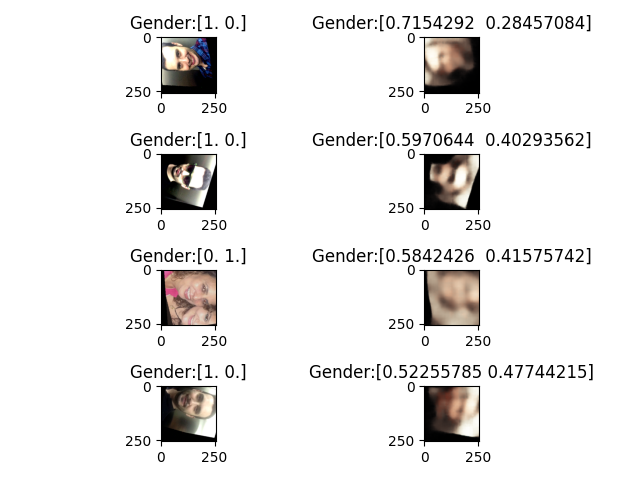

In [49]:
fig2, ax2 = plt.subplots(nrows=TRAIN_BATCH_SIZE, ncols=2)

if(TRAIN_BATCH_SIZE is None or TRAIN_BATCH_SIZE == 1):
    ax2[0].imshow(x/255)
    ax2[0].set_title(y['gender'])
    
    ax2[1].imshow(out['recon']/255)
    ax2[1].set_title(out['gender'])
else:
    for i in range(TRAIN_BATCH_SIZE):
        ax2[i, 0].imshow(x[i]/255)
        ax2[i, 0].set_title(f"Gender:{y['gender'][i]}")
        
        ax2[i, 1].imshow(out['recon'][i]/255)
        ax2[i, 1].set_title(f"Gender:{out['gender'][i]}")
        
plt.tight_layout()

In [50]:
for xTest, yTest in folds[0][1].take(1):
    pass

In [51]:
outTest = model(xTest)

In [52]:
outTest

{'recon': <tf.Tensor: shape=(4, 256, 256, 3), dtype=float32, numpy=
 array([[[[1.11337829e+00, 1.48442078e+00, 1.09592199e+00],
          [2.11393309e+00, 2.14814639e+00, 1.55819762e+00],
          [2.54482222e+00, 3.16646123e+00, 1.62606192e+00],
          ...,
          [2.14608693e+00, 2.37934113e+00, 2.43695354e+00],
          [8.26979995e-01, 8.66649866e-01, 9.06061411e-01],
          [2.38095224e-01, 2.84270346e-01, 3.28294784e-01]],
 
         [[1.45127892e+00, 1.51317763e+00, 1.10615861e+00],
          [9.07991648e-01, 1.95361197e+00, 1.41386616e+00],
          [3.55873704e+00, 4.08925676e+00, 2.70477843e+00],
          ...,
          [1.44313979e+00, 1.95691013e+00, 2.06978703e+00],
          [8.27276409e-01, 1.05011165e+00, 1.08079886e+00],
          [3.90847027e-01, 5.22084355e-01, 5.72522879e-01]],
 
         [[3.96063375e+00, 3.44284320e+00, 1.98036253e+00],
          [4.58023643e+00, 3.46761799e+00, 1.73852825e+00],
          [4.03546715e+00, 3.47513390e+00, 1.57176280e+0

<IPython.core.display.Javascript object>


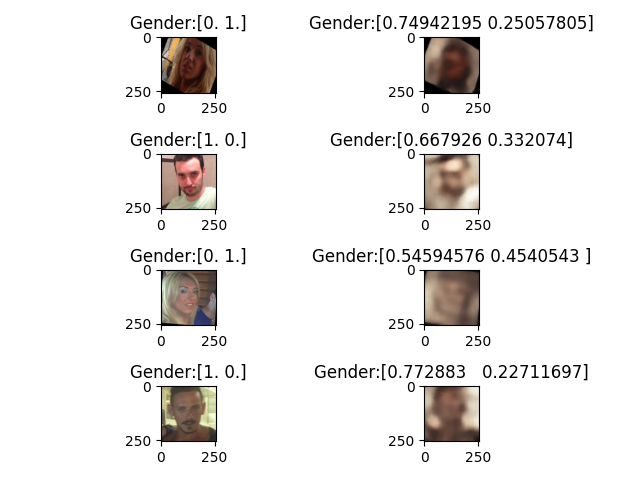

In [53]:
fig3, ax3 = plt.subplots(nrows=VAL_BATCH_SIZE, ncols=2)

if(VAL_BATCH_SIZE is None or VAL_BATCH_SIZE == 1):
    ax3[0].imshow(x/255)
    ax3[0].set_title(yTest['gender'])
    
    ax3[1].imshow(out['recon']/255)
    ax3[1].set_title(outTest['gender'])
else:
    for i in range(TRAIN_BATCH_SIZE):
        ax3[i, 0].imshow(xTest[i]/255)
        ax3[i, 0].set_title(f"Gender:{yTest['gender'][i]}")
        
        ax3[i, 1].imshow(outTest['recon'][i]/255)
        ax3[i, 1].set_title(f"Gender:{outTest['gender'][i]}")
        
plt.tight_layout()